# MNS - Biological Plausible Deep Learning

In [1]:
!pip install -r requirements.txt --quiet

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Import Packages
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

# Import tf for tensorboard monitoring of training
import tensorflow as tf

# Import Network Architectures
from DNN import DNN, eval_dnn
from CNN import CNN, eval_cnn

# Import log-helper/learning plot functions
from helpers import *
from plotting import *
from logger import get_latest_log_fname, process_logger

# Import Bayesian Optimization Module
from bayesian_opt import BO_NN

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print("Torch Device: {}".format(torch.cuda.get_device_name(0)))
else:
    print("Torch Device: Local CPU")

Torch Device: Local CPU


In [5]:
data_dir = "/Users/rtl/Dropbox/DATASETS"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print("Created New Data Directory")

# Create Log Directory or remove tensorboard log files in log dir
log_dir = os.getcwd() + "/logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    print("Created New Log Directory")
else:
    filelist = [ f for f in os.listdir(log_dir) if f.startswith("events") ]
    for f in filelist:
        os.remove(os.path.join(log_dir, f))
    print("Deleted Old TF Log Files in Existing Log Directory")
    
models_dir = os.getcwd() + "/models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print("Created New Model Directory")

Deleted Old TF Log Files in Existing Log Directory


# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data', 
                                             train=True, 
                                             transform=transforms.ToTensor(),  
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data', 
                                            train=False, 
                                            transform=transforms.ToTensor())

In [6]:
# MNIST dataset
X, y = get_data(num_samples=70000, dataset="MNIST")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=0)

# Simple Feedforward Neural Net

In [7]:
# Define batchsize for data-loading/Epochs for training
batch_size = 100
num_epochs = 5
learning_rate = 0.001

# Instantiate the model with layersize and Logging directory
dnn_model = DNN(h_sizes=[784, 500], out_size=10)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=learning_rate)

In [8]:
model = train_model("dnn", dnn_model, num_epochs,
                    X, y, batch_size,
                    device, optimizer, criterion,
                    model_fname ="models/temp_model_dnn.ckpt",
                    verbose=True, logging=True)

# Get test error
score = get_test_error("dnn", device, model, X_test, y_test)
print("Test Accuracy: {}".format(score))

train | epoch  1 | acc: 0.9109 | loss: 0.3177 | time: 2.98
valid | epoch  1 | acc: 0.9525 | loss: 0.1637 | time: 0.25
--------------------------------------------------
train | epoch  2 | acc: 0.9641 | loss: 0.1239 | time: 3.73
valid | epoch  2 | acc: 0.9680 | loss: 0.1086 | time: 0.23
--------------------------------------------------
train | epoch  3 | acc: 0.9770 | loss: 0.0796 | time: 3.85
valid | epoch  3 | acc: 0.9729 | loss: 0.0906 | time: 0.23
--------------------------------------------------
train | epoch  4 | acc: 0.9840 | loss: 0.0559 | time: 3.80
valid | epoch  4 | acc: 0.9748 | loss: 0.0831 | time: 0.24
--------------------------------------------------
train | epoch  5 | acc: 0.9890 | loss: 0.0403 | time: 3.85
valid | epoch  5 | acc: 0.9759 | loss: 0.0800 | time: 0.23
--------------------------------------------------
Test Accuracy: 0.986171428571


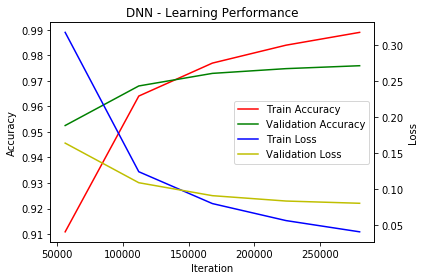

In [9]:
log_fname = get_latest_log_fname(log_dir)
its, train_loss, val_loss, train_acc, val_acc = process_logger(log_fname)
plot_learning(its, train_acc, val_acc, train_loss, val_loss, "DNN - Learning Performance")

In [10]:
# Run 3-fold cross-validation on specific architecture
eval_dnn(batch_size, learning_rate,
         num_layers=1, h_l_1=500,
         num_epochs=5, k_fold=3, verbose=True)

Batchsize: 100
Learning Rate: 0.001
Architecture of Cross-Validated Network:
	 Layer 0: 784 Units
	 Layer 1: 500 Units
Cross-Validation Score Fold 1: 0.970774768598
Cross-Validation Score Fold 2: 0.969613851626
Cross-Validation Score Fold 3: 0.971668595431


0.970685738551766

In [26]:
# Run Bayesian Optimization (UCB-Acquisition Fct) on DNN
hyper_space_dnn = {'batch_size': (10, 500),
                   'learning_rate': (0.0001, 0.05),
                   'num_layers': (1, 6),
                   'h_l_1': (30, 500),
                   'h_l_2': (30, 500),
                   'h_l_3': (30, 500),
                   'h_l_4': (30, 500),
                   'h_l_5': (30, 500),
                   'h_l_6': (30, 500)}

opt_log = BO_NN(2, eval_dnn, "dnn", hyper_space_dnn,
                num_epochs=5, k_fold=3, logging=True, verbose=True)

Loaded previously existing Log with 10 BO iterations.
Start Logging to ./logs/bo_logs_dnn.json
BO iter  1 | cv-acc: 0.8990 | best-acc: 0.9607 | time: 29.05
BO iter  2 | cv-acc: 0.8989 | best-acc: 0.9607 | time: 32.28
Merged JSON logs - Total iterations: 12
Removed temporary log file.


# Simple Convolutional Neural Network

In [ ]:
# ConvNet Parameters
batch_size = 100
ch_sizes = [1, 16, 32]
k_sizes = [5, 5]
stride = 1
padding = 2
out_size = 10
num_epochs = 2
learning_rate = 0.001

# Instantiate the model with layersizes, Loss fct, optimizer
cnn_model = CNN(ch_sizes, k_sizes,
                stride, padding, out_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [ ]:
model = train_model("cnn", cnn_model, num_epochs,
                    X, y, batch_size,
                    device, optimizer, criterion,
                    model_fname ="models/temp_model_cnn.ckpt",
                    verbose=True, logging=True)

# Get test error
score = get_test_error("cnn", device, model, X_test, y_test)
print("Test Accuracy: {}".format(score))

In [ ]:
log_fname = get_latest_log_fname(log_dir)
its, train_loss, val_loss, train_acc, val_acc = process_logger(log_fname)
plot_learning(its, train_acc, val_acc, train_loss, val_loss, "CNN - Learning Performance")

In [ ]:
# Run 3-fold cross-validation on specific architecture
eval_cnn(batch_size, learning_rate, num_layers=2,
         ch_1=16, ch_2=32, k_1=5, k_2=5,
         stride=1, padding=2,
         k_fold=2, verbose=True)

In [ ]:
# Run Bayesian Optimization (UCB-Acquisition Fct) on DNN
hyper_space_cnn = {'batch_size': (10, 500),
                   'learning_rate': (0.0001, 0.05),
                   'num_layers': (1, 5),
                   'ch_1': (3, 64),
                   'ch_2': (3, 64),
                   'ch_3': (3, 64),
                   'ch_4': (3, 64),
                   'ch_5': (3, 64),
                   'k_1': (2, 10),
                   'k_2': (2, 10),
                   'k_3': (2, 10),
                   'k_4': (2, 10),
                   'k_5': (2, 10),
                   'stride': (1, 3),
                   'padding': (1, 3)}

opt_log = BO_NN(3, eval_cnn, "cnn", hyper_space_cnn, logging=False, verbose=True)